Loading packages and data

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import trompy as tp
from scipy import stats

In [2]:
# read in data
PATH_TO_WORKBOOK = Path("../data/")
EXCEL_WORKBOOK = "measurements_b3_2.xlsx"
rows, header = tp.metafilereader(PATH_TO_WORKBOOK / EXCEL_WORKBOOK, sheetname="metafile_niacin_2")

grouping the animals and exploring the data frame

In [3]:
def get_value(row):
    if row['sex'] == 'female' and row['diet'] == 'control' and row['sucrose'] == 'Yes':
        return 0
    elif row['sex'] == 'female' and row['diet'] == 'control' and row['sucrose'] == 'No':
        return 1
    elif row['sex'] == 'female' and row['diet'] == 'experimental' and row['sucrose'] == 'Yes':
        return 2
    elif row['sex'] == 'female' and row['diet'] == 'experimental' and row['sucrose'] == 'No':
        return 3
    elif row['sex'] == 'male' and row['diet'] == 'control' and row['sucrose'] == 'Yes':
        return 4
    elif row['sex'] == 'male' and row['diet'] == 'control' and row['sucrose'] == 'No':
        return 5
    elif row['sex'] == 'male' and row['diet'] == 'experimental' and row['sucrose'] == 'Yes':
        return 6
    elif row['sex'] == 'male' and row['diet'] == 'experimental' and row['sucrose'] == 'No':
        return 7
    else:
        return -1

def tweak_df(df):
    
    return (df
            # .query("bodyweight != ''")
            .query("animal_id != 'B3201'") ##this line removes the animal removed from the study
            .query("bodyweight.notna()", engine="python")
            .astype({"sex": "category",
                     "diet": "category",
                     "date": object, 
                     "bodyweight": float,
                     "food_yesterday": float,
                     "food_intake": float,
                     "sucrose_intake": float
                     }
                    )
             .assign(groupn = lambda df_: df_.apply(get_value, axis=1))
            )
    
df = tweak_df(pd.DataFrame(rows, columns=header))


In [4]:
df

,animal_id,sex,diet,date,sucrose,bodyweight,food_yesterday,food_today,food_intake,sucrose_yesterday,sucrose_today,sucrose_intake,None,None,None,groupn
1,B3202,female,control,2024-04-06 00:00:00,No,21.0,-1.0,98.6,-1.000000,-1,-1,-1.0,None,None,None,1
2,B3203,female,experimental,2024-04-06 00:00:00,No,21.2,-1.0,139.3,-1.000000,-1,-1,-1.0,None,None,None,3
3,B3204,female,experimental,2024-04-06 00:00:00,No,20.4,-1.0,139.3,-1.000000,-1,-1,-1.0,None,None,None,3
4,B3205,female,control,2024-04-06 00:00:00,No,19.8,-1.0,80.2,-1.000000,-1,-1,-1.0,None,None,None,1
5,B3206,female,control,2024-04-06 00:00:00,No,19.3,-1.0,81.9,-1.000000,-1,-1,-1.0,None,None,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,B3244,male,experimental,2024-05-27 00:00:00,No,32.2,58.1,49.1,3.000000,-1,-1,-1.0,None,None,None,7
860,B3245,male,experimental,2024-05-27 00:00:00,No,31.4,62.9,53.1,3.266667,-1,-1,-1.0,None,None,None,7
861,B3246,male,experimental,2024-05-27 00:00:00,No,34.8,56.8,45.5,3.766667,-1,-1,-1.0,None,None,None,7
862,B3247,male,experimental,2024-05-27 00:00:00,Yes,33.0,38.4,32.9,1.833333,55.5,37.2,6.1,None,None,None,6


In [5]:
print

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [6]:
df.dtypes

animal_id              object
sex                  category
diet                 category
date                   object
sucrose                object
bodyweight            float64
food_yesterday        float64
food_today             object
food_intake           float64
sucrose_yesterday      object
sucrose_today          object
sucrose_intake        float64
None                   object
None                   object
None                   object
groupn                  int64
dtype: object

In [7]:
df.columns

Index([        'animal_id',               'sex',              'diet',
                    'date',           'sucrose',        'bodyweight',
          'food_yesterday',        'food_today',       'food_intake',
       'sucrose_yesterday',     'sucrose_today',    'sucrose_intake',
                      None,                None,                None,
                  'groupn'],
      dtype='object')

In [8]:
df.animal_id.unique()
df.date.unique()

array([Timestamp('2024-04-06 00:00:00'), Timestamp('2024-04-09 00:00:00'),
       Timestamp('2024-04-12 00:00:00'), Timestamp('2024-04-15 00:00:00'),
       Timestamp('2024-04-18 00:00:00'), Timestamp('2024-04-21 00:00:00'),
       Timestamp('2024-04-24 00:00:00'), Timestamp('2024-04-27 00:00:00'),
       Timestamp('2024-04-30 00:00:00'), Timestamp('2024-05-03 00:00:00'),
       Timestamp('2024-05-06 00:00:00'), Timestamp('2024-05-09 00:00:00'),
       Timestamp('2024-05-12 00:00:00'), Timestamp('2024-05-15 00:00:00'),
       Timestamp('2024-05-18 00:00:00'), Timestamp('2024-05-21 00:00:00'),
       Timestamp('2024-05-24 00:00:00'), Timestamp('2024-05-27 00:00:00')],
      dtype=object)

In [9]:
df.groupby(["sex", "diet", "date"]).mean(numeric_only=True).reset_index()

,sex,diet,date,bodyweight,food_yesterday,food_intake,sucrose_intake,groupn
0,female,control,2024-04-06,20.627273,-1.000000,-1.000000,-1.000000,1.000000
1,female,control,2024-04-09,20.418182,79.336364,2.751515,-1.000000,1.000000
2,female,control,2024-04-12,20.809091,69.445455,2.978788,-1.000000,0.454545
3,female,control,2024-04-15,21.145455,58.827273,2.300000,2.290909,0.454545
4,female,control,2024-04-18,21.845455,58.981818,2.357576,2.303030,0.454545
...,...,...,...,...,...,...,...,...
67,male,experimental,2024-05-15,31.316667,43.458333,2.388889,2.525000,6.500000
68,male,experimental,2024-05-18,32.516667,52.841667,2.766667,1.877778,6.500000
69,male,experimental,2024-05-21,32.808333,44.541667,2.516667,2.405556,6.500000
70,male,experimental,2024-05-24,33.358333,49.716667,2.641667,1.986111,6.500000


In [10]:
# remove outliers
# is done by creating the new dataframe df_food_water
# Clean up df


def replace_outliers(df, column):
    
    values=[]
    for idx, row in df.iterrows():
        if row[column] < 0.3:
            values.append(np.nan)
        elif row[column] > np.mean(df[column]) * 2:
            values.append(np.nan)
        else:
            values.append(row[column])
    
    print("the number of outliers being replaced for", column, "is", np.sum(np.isnan(values)))
    df[column] = values
    mean_by_animal = df.groupby(["animal_id"]).mean(numeric_only=True).reset_index()
            
    values=[]
    for idx, row in df.iterrows():
        if np.isnan(row[column]):
            values.append(mean_by_animal.query('animal_id == @row.animal_id')[column].values[0])
        else:
            values.append(row[column])
    
    return values
    
def remove_and_clean(df):
    """Removes unecessary rows and cleans data to get rid of erroneous values.

    Args:
        df (Pandas dataframe): Contains data from niacin experiment

    Returns:
        Dataframe: Cleaned dataframe
    """
    return (df
            .query("food_yesterday != -1.0")
            
            .assign(food_intake = lambda df_: replace_outliers(df_, "food_intake"))
            .assign(bodyweight = lambda df_: replace_outliers(df_, "bodyweight"))
    )

df_food_water = remove_and_clean(df)

# need function to replace sucrose leak values with something reasonable

the number of outliers being replaced for food_intake is 8
the number of outliers being replaced for bodyweight is 7


# Data visualisation

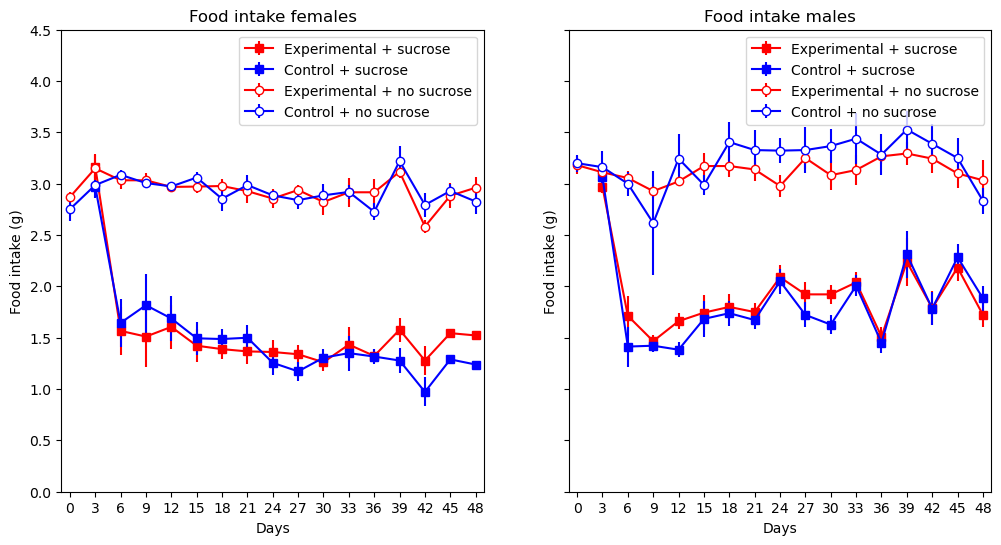

In [11]:
# Find mean and SEM of all data - food intake
mean_fw = df_food_water.groupby(["sex", "diet", "sucrose", "date"]).mean(numeric_only=True).reset_index()
sem_fw = df_food_water.groupby(["sex", "diet", "sucrose","date"]).sem(numeric_only=True).reset_index()

# Generate figure with two subplots
f, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True,
                     gridspec_kw={"width_ratios": [1, 1]},)

# Females

# Set x values
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48]

# Plot data for each group in first subplot
ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'").food_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").food_intake,
               marker="s", markerfacecolor="red", color="red",
               label="Experimental + sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'control'").food_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").food_intake,
               marker="s", markerfacecolor="blue", color="blue",
               label="Control + sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'No' and diet == 'experimental'").food_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose == 'No' and diet == 'experimental'").food_intake,
               marker="o", markerfacecolor="white", color="red",
               label="Experimental + no sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'No' and diet == 'control'").food_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose == 'No' and diet == 'control'").food_intake,
               marker="o", markerfacecolor="white", color="blue",
               label="Control + no sucrose"
              )

# Set x axis limits and ticks
ax[0].set_xlim([-1, x[-1]+1])
ax[0].set_xticks(np.arange(0, x[-1]+1, 3)) 
ax[0].set_ylim([0, 4.5])

# Add labels
ax[0].set_ylabel("Food intake (g)")
ax[0].set_xlabel("Days")
ax[0].legend()
ax[0].set_title("Food intake females")



# Males
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48]

# Plot data for each group in first subplot
ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'").food_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").food_intake,
               marker="s", markerfacecolor="red", color="red",
               label="Experimental + sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'control'").food_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").food_intake,
               marker="s", markerfacecolor="blue", color="blue",
               label="Control + sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'No' and diet == 'experimental'").food_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose == 'No' and diet == 'experimental'").food_intake,
               marker="o", markerfacecolor="white", color="red",
               label="Experimental + no sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'No' and diet == 'control'").food_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose == 'No' and diet == 'control'").food_intake,
               marker="o", markerfacecolor="white", color="blue",
               label="Control + no sucrose"
              )

# Set x axis limits and ticks
ax[1].set_xlim([-1, x[-1]+1])
ax[1].set_xticks(np.arange(0, x[-1]+1, 3)) 
ax[1].set_ylim([0, 4.5])

# Add labels
ax[1].set_ylabel("Food intake (g)")
ax[1].set_xlabel("Days")
ax[1].legend()
ax[1].set_title("Food intake males")


f.savefig("..//results//foodintake.png")

In [12]:
## for when you kinda want the dots/datapoints of the graph not to overlap, add this to some of them
## use it instead of the x at the errorbar
[xval + 0.1 for xval in x]

[0.1,
 3.1,
 6.1,
 9.1,
 12.1,
 15.1,
 18.1,
 21.1,
 24.1,
 27.1,
 30.1,
 33.1,
 36.1,
 39.1,
 42.1,
 45.1,
 48.1]

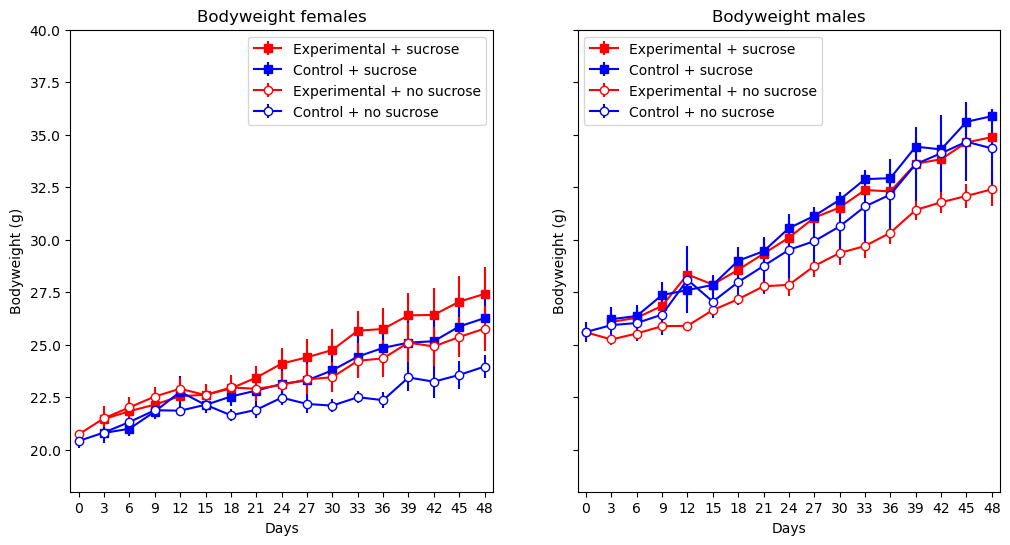

In [13]:
# Find mean and SEM of all data - body weight
mean_fw = df_food_water.groupby(["sex", "diet", "sucrose", "date"]).mean(numeric_only=True).reset_index()
sem_fw = df_food_water.groupby(["sex", "diet", "sucrose","date"]).sem(numeric_only=True).reset_index()

# Generate figure with two subplots
f, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True,
                     gridspec_kw={"width_ratios": [1, 1]},)

# Females

# Set x values
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48]

# Plot data for each group in first subplot
ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'").bodyweight,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").bodyweight,
               marker="s", markerfacecolor="red", color="red",
               label="Experimental + sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'control'").bodyweight,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").bodyweight,
               marker="s", markerfacecolor="blue", color="blue",
               label="Control + sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'No' and diet == 'experimental'").bodyweight,
               yerr=sem_fw.query("sex == 'female' and sucrose == 'No' and diet == 'experimental'").bodyweight,
               marker="o", markerfacecolor="white", color="red",
               label="Experimental + no sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'No' and diet == 'control'").bodyweight,
               yerr=sem_fw.query("sex == 'female' and sucrose == 'No' and diet == 'control'").bodyweight,
               marker="o", markerfacecolor="white", color="blue",
               label="Control + no sucrose"
              )

# Set x axis limits and ticks
ax[0].set_xlim([-1, x[-1]+1])
ax[0].set_xticks(np.arange(0, x[-1]+1, 3)) 
ax[0].set_ylim([18, 40])

# Add labels
ax[0].set_ylabel("Bodyweight (g)")
ax[0].set_xlabel("Days")
ax[0].legend()
ax[0].set_title("Bodyweight females")



# Males
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48]

# Plot data for each group in first subplot
ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'").bodyweight,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").bodyweight,
               marker="s", markerfacecolor="red", color="red",
               label="Experimental + sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'control'").bodyweight,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").bodyweight,
               marker="s", markerfacecolor="blue", color="blue",
               label="Control + sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'No' and diet == 'experimental'").bodyweight,
               yerr=sem_fw.query("sex == 'male' and sucrose == 'No' and diet == 'experimental'").bodyweight,
               marker="o", markerfacecolor="white", color="red",
               label="Experimental + no sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'No' and diet == 'control'").bodyweight,
               yerr=sem_fw.query("sex == 'male' and sucrose == 'No' and diet == 'control'").bodyweight,
               marker="o", markerfacecolor="white", color="blue",
               label="Control + no sucrose"
              )

# Set x axis limits and ticks
ax[1].set_xlim([-1, x[-1]+1])
ax[1].set_xticks(np.arange(0, x[-1]+1, 3)) 
ax[1].set_ylim([18, 40])

# Add labels
ax[1].set_ylabel("Bodyweight (g)")
ax[1].set_xlabel("Days")
ax[1].legend()
ax[1].set_title("Bodyweight males")


f.savefig("..//results//bodyweight.png")

In [14]:
# sucrose has some outliers as well, that will be removed in this cell. However, for whatever reason as soon as this is done,
# the rest of the dataset becomes completely off for the other figures. Therefore, the cleaned dataset will be stored in a 
# new dataset.

import numpy as np

def replace_outliers(df_food_water, column):
    values = []
    for idx, row in df_food_water.iterrows():
        if row[column] in [-1, -2]:  # Checking for both -1 and -2
            values.append(np.nan)
        else:
            values.append(row[column])

    print("The number of outliers being replaced for", column, "is", np.sum(np.isnan(values)))
    df_food_water[column] = values
    mean_by_animal = df_food_water.groupby(["animal_id"]).mean(numeric_only=True).reset_index()

    values = []
    for idx, row in df_food_water.iterrows():
        if np.isnan(row[column]):
            values.append(mean_by_animal.query('animal_id == @row.animal_id')[column].values[0])
        else:
            values.append(row[column])

    return values

def remove_and_clean(df_food_water):
    return (df_food_water
            .assign(food_intake=lambda df_food_water: replace_outliers(df_food_water, "sucrose_intake")))

df_sucrose = remove_and_clean(df_food_water)


The number of outliers being replaced for sucrose_intake is 441


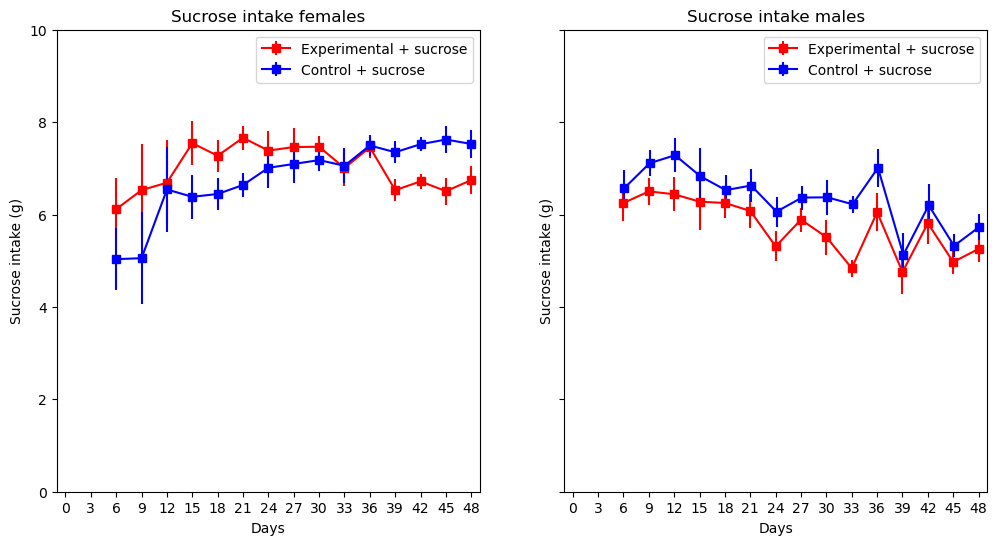

In [15]:
# Find mean and SEM of all data - food intake
mean_fw = df_sucrose.groupby(["sex", "diet", "sucrose", "date"]).mean(numeric_only=True).reset_index()
sem_fw = df_sucrose.groupby(["sex", "diet", "sucrose","date"]).sem(numeric_only=True).reset_index()

# Generate figure with two subplots
f, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True,
                     gridspec_kw={"width_ratios": [1, 1]},)

# Females

# Set x values
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48]

# Plot data for each group in first subplot
ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'").sucrose_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").sucrose_intake,
               marker="s", markerfacecolor="red", color="red",
               label="Experimental + sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'control'").sucrose_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").sucrose_intake,
               marker="s", markerfacecolor="blue", color="blue",
               label="Control + sucrose"
              )

# Set x axis limits and ticks
ax[0].set_xlim([-1, x[-1]+1])
ax[0].set_xticks(np.arange(0, x[-1]+1, 3)) 
ax[0].set_ylim([0, 10])

# Add labels
ax[0].set_ylabel("Sucrose intake (g)")
ax[0].set_xlabel("Days")
ax[0].legend()
ax[0].set_title("Sucrose intake females")



# Males
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48]

# Plot data for each group in first subplot
ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'").sucrose_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").sucrose_intake,
               marker="s", markerfacecolor="red", color="red",
               label="Experimental + sucrose"
              )

ax[1].errorbar([xval + 0.1 for xval in x],
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'control'").sucrose_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").sucrose_intake,
               marker="s", markerfacecolor="blue", color="blue",
               label="Control + sucrose"
              )

# Set x axis limits and ticks
ax[1].set_xlim([-1, x[-1]+1])
ax[1].set_xticks(np.arange(0, x[-1]+1, 3)) 
ax[1].set_ylim([0, 10])

# Add labels
ax[1].set_ylabel("Sucrose intake (g)")
ax[1].set_xlabel("Days")
ax[1].legend()
ax[1].set_title("Sucrose intake males")


f.savefig("..//results//sucroseintake.png")

Text(0.5, 1.0, 'Female control no sucrose data')

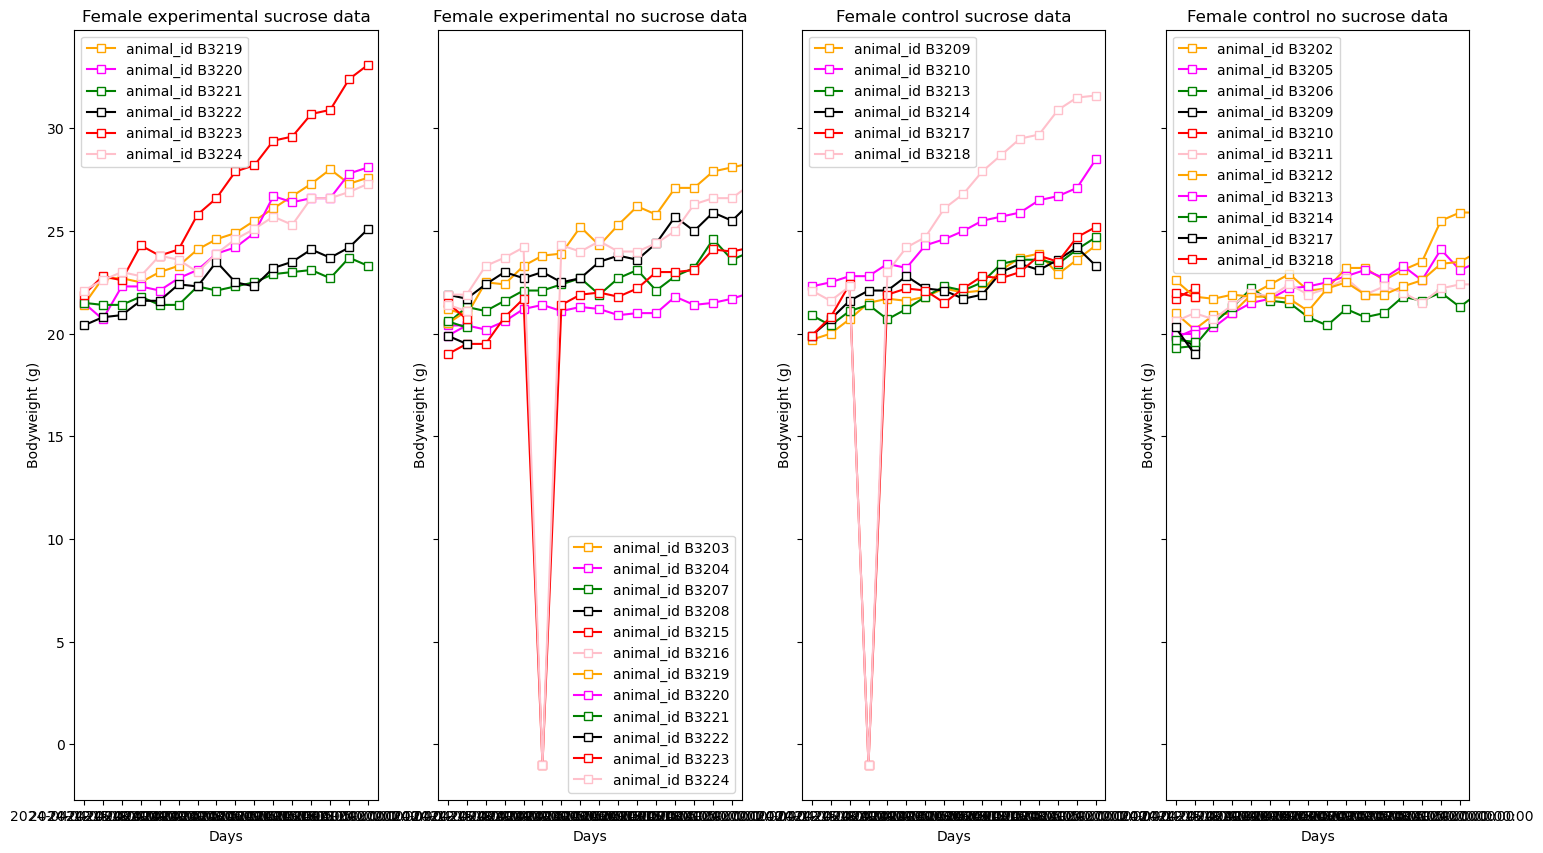

In [16]:
#Now look at the body weight for all individuals (in case some individuals respond weirdly / a lot whilst others don't at all)
#Females first

#Subset the DataFrames into four
female_experimental_sucrose_data = df[(df['sex'] == 'female') & (df['diet'] == 'experimental') & (df['sucrose'] == 'Yes')]
female_experimental_no_sucrose_data = df[(df['sex'] == 'female') & (df['diet'] == 'experimental') & (df['sucrose'] == 'No')]
female_control_sucrose_data = df[(df["sex"] == "female") & (df["diet"] == "control") & (df['sucrose'] == 'Yes')]
female_control_no_sucrose_data = df[(df["sex"] == "female") & (df["diet"] == "control") & (df['sucrose'] == 'No')]

# Set x values based on the number of days
x_values0 = np.arange(len(female_experimental_sucrose_data['date'].unique()))
x_values1 = np.arange(len(female_experimental_no_sucrose_data['date'].unique()))
x_values2 = np.arange(len(female_control_sucrose_data['date'].unique()))
x_values3 = np.arange(len(female_control_no_sucrose_data['date'].unique()))

# Create a subplot
fig, ax = plt.subplots(ncols=4, figsize=(18, 10), sharey=True,
                     gridspec_kw={"width_ratios": [1, 1, 1, 1]})

# Get unique samples in the dataset
samples0 = female_experimental_sucrose_data['animal_id'].unique()
samples1 = female_experimental_no_sucrose_data['animal_id'].unique()
samples2 = female_control_sucrose_data["animal_id"].unique()
samples3 = female_control_no_sucrose_data["animal_id"].unique()

# Colour of lines
palette = ["orange", "magenta", "green", "black", "red", "pink"]

# Loop through each sample and plot the connected data points
for i, sample in enumerate(samples0):
    sample_data = female_experimental_sucrose_data[female_experimental_sucrose_data['animal_id'] == sample]
    ax[0].plot(x_values0[:len(sample_data)], 
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")

for i, sample in enumerate(samples1):
    sample_data = female_experimental_no_sucrose_data[female_experimental_no_sucrose_data['animal_id'] == sample]
    ax[1].plot(x_values1[:len(sample_data)],  
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")

for i, sample in enumerate(samples2):
    sample_data = female_control_sucrose_data[female_control_sucrose_data['animal_id'] == sample]
    ax[2].plot(x_values2[:len(sample_data)],  
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")

for i, sample in enumerate(samples3):
    sample_data = female_control_no_sucrose_data[female_control_no_sucrose_data['animal_id'] == sample]
    ax[3].plot(x_values3[:len(sample_data)], 
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")

# Set x axis limits and ticks
for i in range(4):
    ax[i].set_xlim([-0.5, len(x_values0) - 0.5])
    ax[i].set_xticks(np.arange(len(x_values0)))
    ax[i].set_xticklabels(sorted(female_experimental_sucrose_data['date'].unique()))

    # Add labels
    ax[i].set_ylabel("Bodyweight (g)")
    ax[i].set_xlabel("Days")
    ax[i].legend()

# Set titles for each subplot
ax[0].set_title("Female experimental sucrose data")
ax[1].set_title("Female experimental no sucrose data")
ax[2].set_title("Female control sucrose data")
ax[3].set_title("Female control no sucrose data")

##FOR WHATEVER REASON THE GRAPHS ARE STILL WRONG


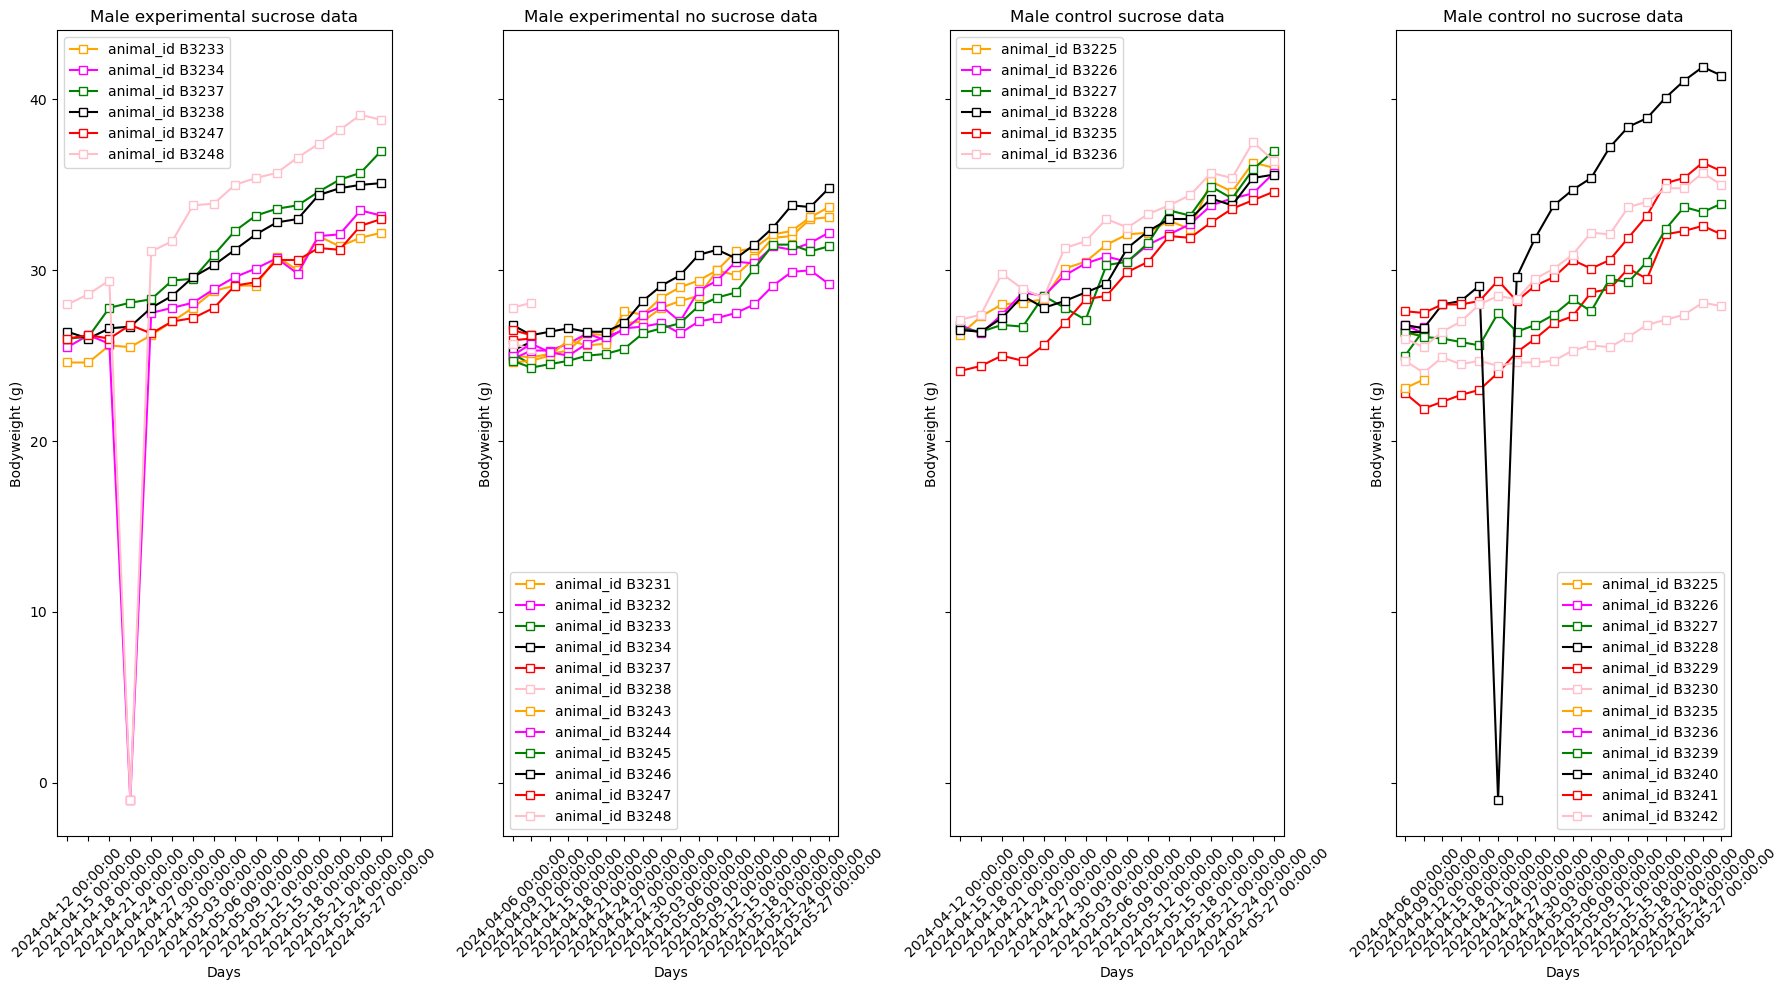

In [17]:
#Now the males

# Subset the DataFrames into four
male_experimental_sucrose_data = df[(df['sex'] == 'male') & (df['diet'] == 'experimental') & (df['sucrose'] == 'Yes')]
male_experimental_no_sucrose_data = df[(df['sex'] == 'male') & (df['diet'] == 'experimental') & (df['sucrose'] == 'No')]
male_control_sucrose_data = df[(df["sex"] == "male") & (df["diet"] == "control") & (df['sucrose'] == 'Yes')]
male_control_no_sucrose_data = df[(df["sex"] == "male") & (df["diet"] == "control") & (df['sucrose'] == 'No')]

# Set x values based on the number of days
x_values4 = np.arange(len(male_experimental_sucrose_data['date'].unique()))
x_values5 = np.arange(len(male_experimental_no_sucrose_data['date'].unique()))
x_values6 = np.arange(len(male_control_sucrose_data['date'].unique()))
x_values7 = np.arange(len(male_control_no_sucrose_data['date'].unique()))

# Create a subplot
fig, ax = plt.subplots(ncols=4, figsize=(18, 10), sharey=True,
                     gridspec_kw={"width_ratios": [1, 1, 1, 1]})

# Get unique samples in the dataset
samples4 = male_experimental_sucrose_data["animal_id"].unique()
samples5 = male_experimental_no_sucrose_data["animal_id"].unique()
samples6 = male_control_sucrose_data["animal_id"].unique()
samples7 = male_control_no_sucrose_data["animal_id"].unique()

# Colour of lines
palette = ["orange", "magenta", "green", "black", "red", "pink"]

# Loop through each sample and plot the connected data points
for i, sample in enumerate(samples4):
    sample_data = male_experimental_sucrose_data[male_experimental_sucrose_data['animal_id'] == sample]
    ax[0].plot(x_values4[:len(sample_data)],
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")
    
for i, sample in enumerate(samples5):
    sample_data = male_experimental_no_sucrose_data[male_experimental_no_sucrose_data['animal_id'] == sample]
    ax[1].plot(x_values5[:len(sample_data)],
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")

for i, sample in enumerate(samples6):
    sample_data = male_control_sucrose_data[male_control_sucrose_data['animal_id'] == sample]
    ax[2].plot(x_values6[:len(sample_data)],
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")

for i, sample in enumerate(samples7):
    sample_data = male_control_no_sucrose_data[male_control_no_sucrose_data['animal_id'] == sample]
    ax[3].plot(x_values7[:len(sample_data)],
               sample_data['bodyweight'],
               marker='s', linestyle='-',
               markerfacecolor="white",
               color=palette[i % len(palette)],
               label=f"animal_id {sample}")

# Set x axis limits and ticks
for i, x_values in enumerate([x_values4, x_values5, x_values6, x_values7]):
    ax[i].set_xlim([-0.5, len(x_values) - 0.5])
    ax[i].set_xticks(np.arange(len(x_values)))
    unique_dates = sorted(eval(f'male_experimental_sucrose_data["date"].unique()')) if i == 0 else sorted(eval(f'male_experimental_no_sucrose_data["date"].unique()')) if i == 1 else sorted(eval(f'male_control_sucrose_data["date"].unique()')) if i == 2 else sorted(eval(f'male_control_no_sucrose_data["date"].unique()'))
    ax[i].set_xticklabels(unique_dates, rotation=45)

    # Add labels
    ax[i].set_ylabel("Bodyweight (g)")
    ax[i].set_xlabel("Days")
    ax[i].legend()

# Set titles for each subplot
ax[0].set_title("Male experimental sucrose data")
ax[1].set_title("Male experimental no sucrose data")
ax[2].set_title("Male control sucrose data")
ax[3].set_title("Male control no sucrose data")

plt.tight_layout()

##FOR WHATEVER REASON THE GRAPHS ARE STILL WRONG

# Data analysis

So first, want to make a factor for the difference in body weight at the beginning and the end of the experiment. 

In [18]:
# Pivot the DataFrame to get weights for specific dates in separate columns, store it in a new one from the previously cleaned up one
df_pivot = df_food_water.pivot(index='animal_id', columns='date', values='bodyweight').reset_index() 

# Calculate the average of the first two and last two dates
dates_first_two = [pd.Timestamp('2024-04-09 00:00:00'), pd.Timestamp('2024-04-12 00:00:00')]  #here data's from the beginning
dates_last_two = [pd.Timestamp('2024-05-24 00:00:00'), pd.Timestamp('2024-05-27 00:00:00')] #here data's from the end

# Calculate the averages 
# okay I don't know why this is necessary but it works
df_pivot['avg_first_two'] = df_pivot[dates_first_two].mean(axis=1)
df_pivot['avg_last_two'] = df_pivot[dates_last_two].mean(axis=1)

# Calculate the difference between these averages
df_pivot['delta_bw'] = df_pivot['avg_last_two'] - df_pivot['avg_first_two']  #now the new factor is made 

In [20]:
df_pivot = df_pivot.assign(groupn= [1,3,3,1,1,3,3,0,0,1,1,0,0,3,3,0,0,2,2,2,2,2,2,4,4,4,4,5,5,7,7,6,6,4,4,6,6,5,5,5,5,7,7,7,7,6,6]) # manually assign dan maar denk ik 

In [21]:
df_pivot.head() #to check if the data set looks like I want it to 

date,animal_id,2024-04-09 00:00:00,2024-04-12 00:00:00,2024-04-15 00:00:00,2024-04-18 00:00:00,2024-04-21 00:00:00,2024-04-24 00:00:00,2024-04-27 00:00:00,2024-04-30 00:00:00,2024-05-03 00:00:00,...,2024-05-12 00:00:00,2024-05-15 00:00:00,2024-05-18 00:00:00,2024-05-21 00:00:00,2024-05-24 00:00:00,2024-05-27 00:00:00,avg_first_two,avg_last_two,delta_bw,groupn
0,B3202,20.2,20.9,21.0,21.9,22.4,22.9,22.1,22.2,23.2,...,23.1,23.5,25.5,25.9,25.9,25.4,20.55,25.65,5.10,1
1,B3203,20.9,22.5,22.4,23.3,23.8,23.9,25.2,24.3,25.3,...,27.1,27.1,27.9,28.1,28.3,29.5,21.70,28.90,7.20,3
2,B3204,20.4,20.2,20.6,21.2,21.4,21.1,21.3,21.2,20.9,...,21.8,21.4,21.5,21.7,22.0,21.7,20.30,21.85,1.55,3
3,B3205,20.2,20.3,21.0,21.5,21.7,22.2,22.3,22.5,22.8,...,23.3,22.6,24.1,23.1,23.5,24.0,20.25,23.75,3.50,1
4,B3206,19.4,20.5,21.3,22.2,21.6,21.5,20.8,20.4,21.2,...,21.8,21.6,22.0,21.3,22.0,22.1,19.95,22.05,2.10,1


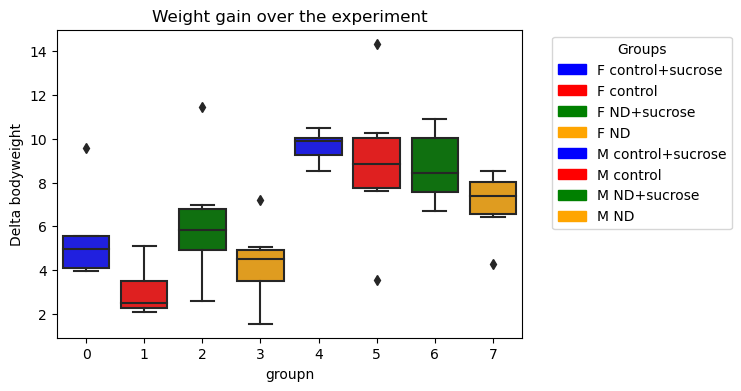

In [36]:
#visualise the new factor delta bodyweight, maybe in a boxplot? 
from matplotlib.patches import Patch

# Create a boxplot
plt.figure(figsize=(6, 4))
palette = ['blue','red','green','orange','blue','red','green','orange']
sns.boxplot(x='groupn', y='delta_bw', palette=palette, data=df_pivot)

# Add title and labels
plt.title('Weight gain over the experiment')
plt.ylabel('Delta bodyweight')

labels = ['F control+sucrose', 'F control', 'F ND+sucrose', 'F ND', 
          'M control+sucrose', 'M control', 'M ND+sucrose', 'M ND']
handles = [Patch(color=palette[i], label=label) for i, label in enumerate(labels)]

# Add the legend
plt.legend(handles=handles, title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left')

f.savefig("..//results//bw_difference.png")

Now try to perform tests on the data

In [48]:
# I realised that also the sucrose, sex and diet groups are missing and since I have no idea how to add that to
# a pivoted dataset, I do it here manually. 
df_pivot = df_pivot.assign(sex = ['female','female','female','female','female','female','female','female','female','female','female',
                                 'female','female','female','female','female','female','female','female','female','female','female','female',
                                 'male','male','male','male','male','male','male','male','male','male','male','male','male','male','male','male',
                                 'male','male','male','male','male','male','male','male'])
df_pivot = df_pivot.assign(sucrose = ['No','No','No','No','No','No','No','Yes','Yes','No','No','Yes','Yes','No','No','Yes','Yes',
                                    'Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','No','No','No','No',
                                     'Yes','Yes','Yes','Yes','Yes','Yes','No','No','No','No','No','No','No','No','Yes','Yes'])
df_pivot = df_pivot.assign(diet = ['control','experimental','experimental','control','control','experimental','experimental',
                                  'control','control','control','control','control','control','experimental','experimental','control','control',
                                  'experimental','experimental','experimental','experimental','experimental','experimental',
                                  'control','control','control','control','control','control','experimental','experimental','experimental','experimental',
                                  'control','control','experimental','experimental','control','control','control','control',
                                  'experimental','experimental','experimental','experimental','experimental','experimental'])
df_pivot.head()

date,animal_id,2024-04-09 00:00:00,2024-04-12 00:00:00,2024-04-15 00:00:00,2024-04-18 00:00:00,2024-04-21 00:00:00,2024-04-24 00:00:00,2024-04-27 00:00:00,2024-04-30 00:00:00,2024-05-03 00:00:00,...,2024-05-21 00:00:00,2024-05-24 00:00:00,2024-05-27 00:00:00,avg_first_two,avg_last_two,delta_bw,groupn,sex,sucrose,diet
0,B3202,20.2,20.9,21.0,21.9,22.4,22.9,22.1,22.2,23.2,...,25.9,25.9,25.4,20.55,25.65,5.10,1,female,No,control
1,B3203,20.9,22.5,22.4,23.3,23.8,23.9,25.2,24.3,25.3,...,28.1,28.3,29.5,21.70,28.90,7.20,3,female,No,experimental
2,B3204,20.4,20.2,20.6,21.2,21.4,21.1,21.3,21.2,20.9,...,21.7,22.0,21.7,20.30,21.85,1.55,3,female,No,experimental
3,B3205,20.2,20.3,21.0,21.5,21.7,22.2,22.3,22.5,22.8,...,23.1,23.5,24.0,20.25,23.75,3.50,1,female,No,control
4,B3206,19.4,20.5,21.3,22.2,21.6,21.5,20.8,20.4,21.2,...,21.3,22.0,22.1,19.95,22.05,2.10,1,female,No,control


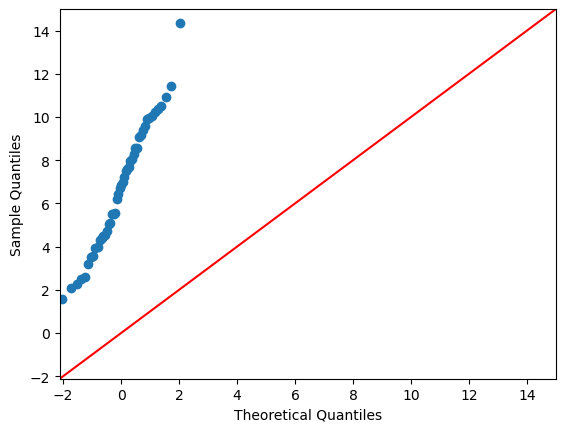

In [40]:
# now try to perform tests on the data
# starting of by confirming the assumptions of an ANOVA

# normality
import statsmodels.api as sm
delta_bw = df_pivot['delta_bw']
fig = sm.qqplot(delta_bw, line='45') #sure it works but what does this say? 
# and am I even checking it correctly? 


In [57]:
#split the dataframe for sex
df_male = df_pivot[df_pivot['sex'] == 'male']
df_female = df_pivot[df_pivot['sex'] == 'female']


date,animal_id,2024-04-09 00:00:00,2024-04-12 00:00:00,2024-04-15 00:00:00,2024-04-18 00:00:00,2024-04-21 00:00:00,2024-04-24 00:00:00,2024-04-27 00:00:00,2024-04-30 00:00:00,2024-05-03 00:00:00,...,2024-05-21 00:00:00,2024-05-24 00:00:00,2024-05-27 00:00:00,avg_first_two,avg_last_two,delta_bw,groupn,sex,sucrose,diet
0,B3202,20.2,20.9,21.0,21.9,22.4,22.9,22.1,22.2,23.2,...,25.9,25.9,25.4,20.55,25.65,5.10,1,female,No,control
1,B3203,20.9,22.5,22.4,23.3,23.8,23.9,25.2,24.3,25.3,...,28.1,28.3,29.5,21.70,28.90,7.20,3,female,No,experimental
2,B3204,20.4,20.2,20.6,21.2,21.4,21.1,21.3,21.2,20.9,...,21.7,22.0,21.7,20.30,21.85,1.55,3,female,No,experimental
3,B3205,20.2,20.3,21.0,21.5,21.7,22.2,22.3,22.5,22.8,...,23.1,23.5,24.0,20.25,23.75,3.50,1,female,No,control
4,B3206,19.4,20.5,21.3,22.2,21.6,21.5,20.8,20.4,21.2,...,21.3,22.0,22.1,19.95,22.05,2.10,1,female,No,control


In [59]:
#why not just already to the two way anova?
import statsmodels.api as sm
from statsmodels.formula.api import ols

#perform two-way ANOVA for males
model = ols('delta_bw ~ C(sucrose) + C(diet) + C(sucrose):C(diet)', data=df_male).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(sucrose),9.003750,1.0,1.972938,0.175477
C(diet),12.041667,1.0,2.638619,0.119950
C(sucrose):C(diet),1.306667,1.0,0.286322,0.598487
Residual,91.272500,20.0,NaN,NaN


In [60]:
#perform two-way ANOVA for females
model = ols('delta_bw ~ C(sucrose) + C(diet) + C(sucrose):C(diet)', data=df_female).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(sucrose),26.298701,1.0,5.512371,0.029864
C(diet),5.551372,1.0,1.163602,0.294224
C(sucrose):C(diet),0.371571,1.0,0.077884,0.783201
Residual,90.646167,19.0,NaN,NaN
